#Analyzing the NYC Subway Dataset
<strong>Author</strong>: Nicholas Hunt-Walker<br/>
<strong>Start Date</strong>: 10/16/2015<br/>
<strong>Purpose</strong>: Answering questions and plotting data from part 2 of this project

## Section 0: Sources Used
- ggplot documentation: [link](https://pypi.python.org/pypi/ggplot)
- $R^2$ clarification: [link](http://www.statsoft.com/Textbook/Multiple-Regression#cresidual)
- The Mann-Whitney U-test: [link](https://epilab.ich.ucl.ac.uk/coursematerial/statistics/non_parametric/wilcox_mann_whitney.html)

In [1]:
import pandas as pd
import numpy as np
from ggplot import *
%matplotlib inline
from scipy.stats import mannwhitneyu
import statsmodels.api as sm

In [2]:
subway_data = pd.read_csv("turnstile_data_master_with_weather.csv")

## Section 1: Statistical Test
<strong>Questions 1.1: 
- Which statistical test did you use to analyze the NYC subway data? 
- Did you use a one-tail or a two-tail P value? 
- What is the null hypothesis? 
- What is your p-critical value?</strong>

/Users/Nick/anaconda/lib/python2.7/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)


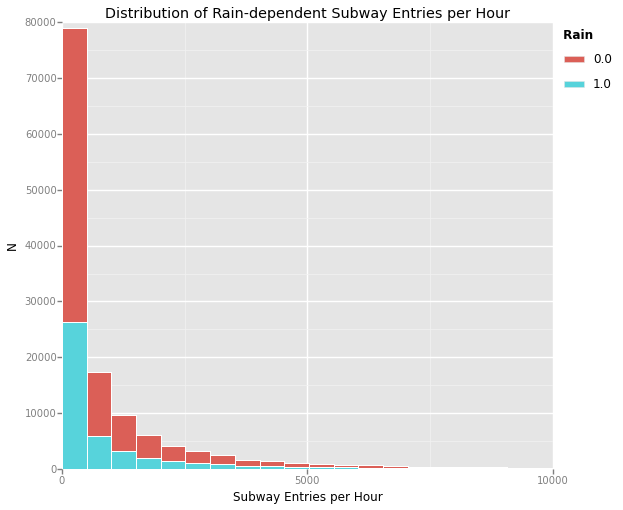

<ggplot: (283937561)>

In [3]:
ggplot(subway_data, aes("ENTRIESn_hourly", fill="rain")) + \
geom_bar(color="white", binwidth=500) + \
ggtitle("Distribution of Rain-dependent Subway Entries per Hour") + \
ylab("N") + xlab("Subway Entries per Hour") + xlim(0,10000)

I chose to use the Mann-Whitney U test.

SciPy's ```mannwhitneyu``` returns the p-value for a one-tailed test. My null hypothesis is that the difference in mean ridership between rainy and non-rainy days is not significantly significant. My alternate hypothesis is simply that there is a statistically significant difference in ridership. Since I'm looking for a simple deviation from statistical congruity, I used the two-tailed test. To do so, I multiplied the output $p$ value by 2.

I chose a critical $p$ value of 0.05. ```manwhitneyu``` returned a value just under that at 0.0249999 (x2) = 0.0499998.

<strong>Question 1.2 
- Why is this statistical test applicable to the dataset? 
- In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.</strong>

The above figure shows that the distribution of subway entries per hour is not Gaussian, $N >> 20$, and the two samples are independent of each other. As such, the previous tests we'd used (e.g. the $t$-test) weren't applicable to this distribution. The Mann-Whitney U-test applies when handling such distributions.

<strong>Question 1.3 
- What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.</strong>

In [4]:
rain = subway_data.rain == 1.0
norain = ~rain

u, p = mannwhitneyu(subway_data[rain].ENTRIESn_hourly, 
                    subway_data[norain].ENTRIESn_hourly)
mean_rainy = subway_data[rain].ENTRIESn_hourly.mean()
mean_norain = subway_data[norain].ENTRIESn_hourly.mean()

fmt_str = "U-statistic: \t\t%.f\np-value: \t\t%.8f\nmean(rainy): \t\t%.3f\nmean(not rainy): \t%.3f"
print fmt_str % (u, p, mean_rainy, mean_norain)

U-statistic: 		1924409167
p-value: 		0.02499991
mean(rainy): 		1105.446
mean(not rainy): 	1090.279


<strong>Question 1.4 
- What is the significance and interpretation of these results?</strong>

At the significance level of $\alpha=0.05$, there's enough evidence to reject the null hypothesis of there being no difference in ridership between rainy days and non-rainy days. However, the difference is so slight and the p-value is so close to showing no statistical significance (at the $\alpha=0.05$ level) that I don't feel confident in that rejection of the null.

## Section 2: Linear Regression
<strong>Question 2.1
- What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model?
</strong>

I used both OLS with Statsmodels and Gradient Descent, but I'm happier with the result from OLS

<strong>Question 2.2
- What features (input variables) did you use in your model?
- Did you use any dummy variables as part of your features?
</strong>

Initially, I got the best results using pretty much every feature:
<blockquote>'Hour', 'precipi', 'rain',
                           'meantempi', 'mintempi', 'maxtempi',
                           'meanpressurei', 'minpressurei', 'maxpressurei',
                           'meandewpti', 'mindewpti', 'maxdewpti',
                           'meanwindspdi'</blockquote>
returning an of $R^2 \approx 0.48257$. However, I wanted something that I could justify beyond "this is what works", so I settled on "Hour", "rain", "mintempi", "maxtempi", and "meanwindspdi" ($R^2 \approx 0.48016$).
                           
I used UNIT as the dummy variable

<strong>Question 2.3
- Why did you select these features in your model? Be specific as to why these would contribute to the predictive power of your model.
</strong>

I chose these features based on intuition about human behavior (and my own behavior having once been a resident of NYC).
- *"Hour"* most definitely because, as is seen later on in section 3, there's a strong correlation between time of day and ridership. More intuitively, there will be peak hours for people entering subways (work start: 8-10am, lunch: 11am-1pm, work end: 3-6pm, party/dinner time: 8-10pm)
- *"rain"* goes hand-in-hand with "precipi". If it's raining, people want to be out of the rain, so they're more likey to be inside or under ground.
- *"mintempi"/"maxtempi"* people care more about the extremes than the averages. Particularly cold/hot weather will drive people to shelter underground
- *"meanwindspdi"* I associate wind speed with particularly terrible storms. The higher the wind speed, the less I want to be outside, and the less likely I am to try to get from point A to point B using surface transport.
- *"precipi"* because the larger the rainfall, the less likely people will opt to walk from point to point outside, or wait for a bus/taxi.

<strong>Note:</strong>
I had previously chosen precipi because I had suspected that the larger the rainfall, the higher the ridership. I have since removed it without much actual change in $R^2$, since "rain" and "precipi" are already highly correlated.

<strong>Question 2.4
- What are the parameters of the non-dummy features in your linear regression model?
</strong>


- Hour:              65.398726
- rain:              78.676564
- mintempi:         -16.378935
- maxtempi:           6.626328
- meanwindspdi:      27.008728

<strong>Question 2.5
- What is your model's $R^2$ value?
</strong>

As mentioned above, I recover $R^2 = 0.48016$ 

<strong>
Question 2.6
- What does this $R^2$ value mean for the goodness of fit for your regression model?
- Do you think this linear model to predict ridership is appropriate for this dataset, given this $R^2$ value?
</strong>

In [5]:
x = np.linspace(0, 100, 1000)
y = -10.0 * x**2 + 20 + np.random.normal(size=x.size)*8
x_test = sm.add_constant(x)
model = sm.OLS(y, x_test)
results = model.fit()
intercept = results.params[0]
params = results.params[1:]

y_pred = intercept  + np.dot(x[:, np.newaxis], params)

In [6]:
def r_squared(values, pred_values):
    rsq_top = np.sum((values - pred_values)**2)
    rsq_bot = np.sum((values - np.mean(values))**2)
    return 1 - rsq_top/rsq_bot
r_squared(y, y_pred)

0.93737931641382544

I wanted to see what the $R^2$ statistic returned for an actual line with a ton of scatter. Even though the spread of the scatter is on par with the data itself, Ordinary Least Squares regression still produces an $R^2$ value near 1.0. So even for a crappy line, if it's linear it's easily predictable.

Compared to this example where I know for a fact that the input data is linear, my $R^2$ value seems to indicate that my linear model is poorly-fit to the data. More specifically, my model can account for about 48% of the variability in the number of subway entries per hour, and the remaining 52% of the variability remains unexplained by my chosen parameters. A linear model is probably inappropriate, and it might be better to consider some polynomial, or a sinusoid (especially considering a correlation of ridership with Hour).

## Section 3: Visualization
<strong>Please include two visualizations that show the relationships between two or more variables in the NYC subway data.

Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure
</strong>

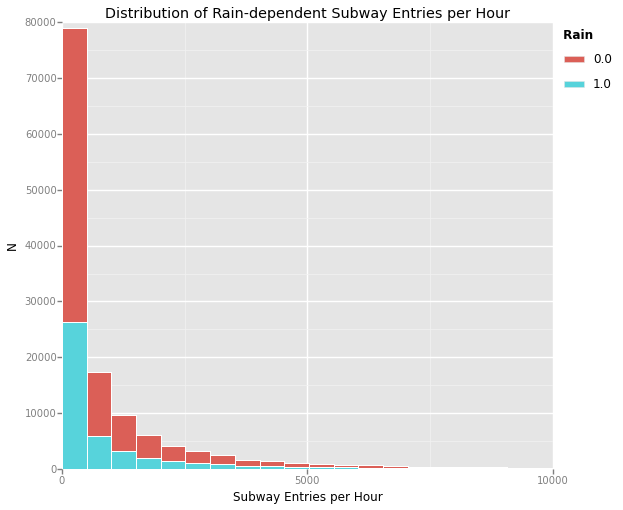

<ggplot: (279621333)>

In [8]:
ggplot(subway_data, aes("ENTRIESn_hourly", fill="rain")) + \
geom_bar(binwidth=500, color="white") + \
ggtitle("Distribution of Rain-dependent Subway Entries per Hour") + \
ylab("N") + xlab("Subway Entries per Hour") + xlim(0,10000)

This is a repetition of the first bar graph above. We're showing the distribution of rain-dependent subway entries per hour. The non-rainy and rainy day data are stacked, with the non-rainy data in red and rainy data in blue. Note that the range of Subway Entries per Hour here is not actually limited to between 0 and 10,000, but the count beyond 10,000 represents only a small fraction of the overall sample (1.333% by count).

This initial plot (without further investigation) might suggest that there's more riders on non-rainy days than rainy days, but it could also just be that when the data was taken it rained far less often than not.

<strong>Question 3.2
- One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. </strong>

In [11]:
hour_grouped_rainy = subway_data[["ENTRIESn_hourly", "EXITSn_hourly"]][rain].groupby(subway_data.Hour).mean().reset_index()
hour_grouped_dry = subway_data[["ENTRIESn_hourly", "EXITSn_hourly"]][norain].groupby(subway_data.Hour).mean().reset_index()
hour_grouped_diff = hour_grouped_rainy.ENTRIESn_hourly - hour_grouped_dry.ENTRIESn_hourly
hour_grouped_diff = hour_grouped_diff.reset_index().rename(columns={"index":"Hour"})
hour_grouped_diff["Rainy"] = hour_grouped_diff.ENTRIESn_hourly > 1

the_plot = ggplot(hour_grouped_diff, aes(x="Hour", y="ENTRIESn_hourly", color="Rainy")) + \
    geom_point(size=125, alpha=0.75) + \
    ylab("Avg Rainy - Avg Non-rainy Entries per Hour") + \
    ggtitle("Differences in Subway Entries per Hour") + \
    xlim(-0.5, 23.5) + ylim(-100,100)
    
# ggsave(the_plot, "subway_entries_differentials.png")

I feel that the above plot a far better illustration of subway ridership between rainy and non-rainy days than a simple bar chart showing frequency of ridership numbers. First, the description. What I've done is found the average of each hour's subway entries for the rainy and non-rainy days, and plotted their difference. The x-axis shows the hour corresponding to each point.

The reason for taking the average as opposed to the sum for each hour is that there weren't an equal number of rainy and non-rainy days. As such, there would be an artifical boost to non-rainy days (which outnumber rainy days), and would produce the illusion that there were more generally more riders on non-rainy days. In reality, just looking at the numbers, it would appear that there are many more riders on rainy days than non-rainy days (on average), as the peak hours generally show more rainy riders than not.

## Section 4: Conclusion
*Please address the following questions in detail. Your answers should be 1-2 paragraphs long.*<br/>
<strong>Question 4.1 & 4.2
- From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it's not raining.
- What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.
</strong>

My analysis begins with testing the hypothesis that there's a significant difference in ridership between rainy and non-rainy days. Using the Mann-Whitney U-test, I see that at the 95% significance level, there is a difference. However it's so slightly below that significance threshold that I hesitate to definitively say there's a difference. For example, if I had rounded the output p-value to the 3rd or 4th decimal place instead of the 8th, it'd be right at that critical value.

Through further analysis and visualization of the hour-to-hour variation of the difference in average subway entries, I'm concluding that on average more people ride the subway when it's raining out. The bar graph wasn't enough to convince me of this, as the extra ridership could just be due to more non-rainy days than rainy ones. Instead, the scatter plot illustrates the difference much better, where overall there's more riders on rainy days than non-rainy ones, and in particular during peak hours there are far more rainy riders on average.

My ordinary least squares regression model backs this up. Though my model's $R^2$ value indicates that my parameters of min/max temperature, rain/not-rain, time, and wind speed only account for ~48% of the variability in ridership, the fit parameters show correlation. Rainfall is strongly positively correlated with ridership ($\theta = 78.677$). The other factors that I'd mentioned (hour of the day, temperature extremes, wind speed) still matter, but *of my chosen parameters* the thing that matters most when it comes to ridership is whether or not it rains.

## Section 5: Reflection
*Please address the following questions in detail. Your answers should be 1-2 paragraphs long.*<br/>
<strong>Question 5.1 

Please discuss potential shortcomings of the methods of your analysis, including: 
1. Dataset
2. Analysis, such as the linear regression model or statistical test.</strong>

One shortcoming of the data is while the turnstile data was hourly, the weather data linked to the turnstile info was an entire day's worth. As such, we really don't get that great of a feel for the hour-to-hour variation of ridership with precipitation, just something averaged over a day. This is insufficient, as we can see from the above scatter plot that there are great variations in ridership throughout the day both for rainy and non-rainy days. Seeing how a heavy downpour might affect the data on an hourly basis would give us a better idae over the influence of rain on ridership.

The shortcoming with the linear regression model should be obvious: the data is likely not linear! As such, no matter how much I refine that linear model, no selection of features is going to produce a good fit to the data. One model that might be looked into so that we can improve upon this linear model is something sinusoidal. Ridership should definitely be periodic with respect to the week, so putting that model forward should produce better results than simple linear regression.

At the behest of the reviewer, I've looked into the shortcomings of the Mann-Whitney U-test (link to info provided at the top; thanks to my team's guide Chris for the source). From what I can tell, the way the U-test works is that the data from both sets are sorted in ascending order and given ranks. The ranks for each are totaled into a value $R$ ($R_1$ and $R_2$). The number from each is also considered, and the $U$ statistic for each is calculated as:
$$U_i = R_i - \frac{n_i(n_i + 1)}{2}$$
where $i$ is the sample number. The lesser of the two U-statistics is used in consideration of statistical significance. The weakness I see is that two samples that are slightly different in distribution, but significantly different in number will have not their actual difference detected as easily as with a parametric test. The small numbered sample, with a few outliers mixed in rank with the large numbered sample, will easily have its U-statistic grow too large to be detected as significantly different.

<strong>Question 5.2 (Optional) 

- Do you have any other insight about the dataset that you would like to share with us?</strong>

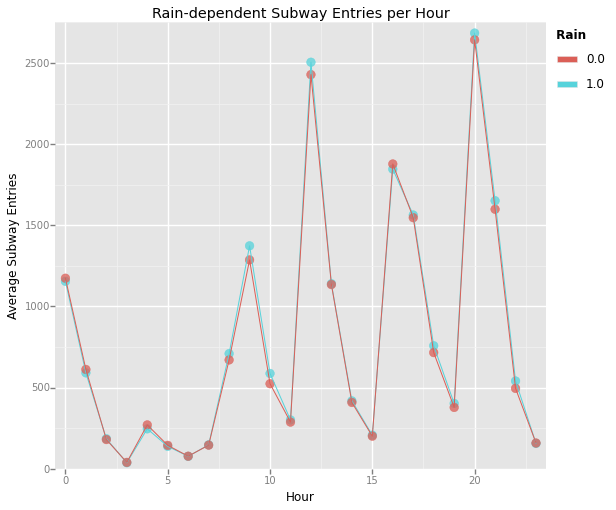

<ggplot: (281391093)>

In [9]:
hour_rain_grouped = subway_data[["ENTRIESn_hourly", "EXITSn_hourly"]].groupby((subway_data.Hour, subway_data.rain)).mean().reset_index()

ggplot(hour_rain_grouped, aes(x="Hour", y="ENTRIESn_hourly", color="rain")) + \
    geom_point(size=75, alpha=0.75) + \
    geom_line() + ylab("Average Subway Entries") + \
    ggtitle("Rain-dependent Subway Entries per Hour") + \
    xlim(-0.5, 23.5) + ylim(0, 2750)


I feel that the above plot a far better illustration of subway ridership than a simple bar chart showing frequency of ridership numbers. First, the description. What I've done is taken the average of each hour's subway entries and plotted them up for the rainy and non-rainy days. The x-axis shows the hour corresponding to each point.
The reason for taking the average as opposed to the sum for each hour is that there weren't an equal number of rainy and non-rainy days. As such, there would be an artifical boost to non-rainy days (which far outnumber rainy days), and would produce the illusion that there were more generally more riders on non-rainy days. In fact, just looking at the numbers here (as well as the other scatter plot above), it would appear that there are hundreds more riders on rainy days than non-rainy days (on average), as the peak hours generally show more rainy riders than not.

There's also some interesting cyclical behavior. I had begun to mention it above in Section 2, but I'll go into it more here. You can clearly see when people are on the move by the local maxima in subway entries. For example, from 8-10 am you have the morning rush, where everyone is usually at work by about 10 so those who remain are the stragglers that are either late or can afford to come into work later than most. The next spike comes up at around 12-1 pm, for the lunch crowd. Some people are meeting at their favorite restaurants, whereas others will be going to the gym, doctor/dentist/therapy appointments, or running errands. It's interesting how the spike is far larger than the morning rush. Maybe people who live in the city already are taking cabs or walking to their jobs in the morning, but hopping on the train for midday activities? Then rush hour hits interestingly enough at 4pm instead of 5 (though 5 isn't far behind in ridership). At 8pm folks are hopping on the subway to visit a bar or go to a restaurant for dinner appointments. Then the midnight crowd is using the trains to go to clubs (or home!)

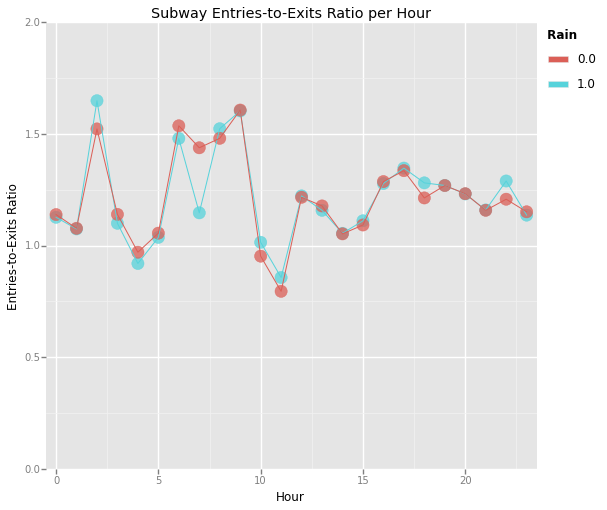

<ggplot: (281660717)>

In [10]:
hour_rain_grouped["Ent/Ex Ratio"] = hour_rain_grouped.ENTRIESn_hourly / hour_rain_grouped.EXITSn_hourly

ggplot(hour_rain_grouped, aes(x="Hour", y="Ent/Ex Ratio", color="rain")) + \
    geom_point(size=150, alpha=0.75) + \
    geom_line() + ylab("Entries-to-Exits Ratio") + \
    ggtitle("Subway Entries-to-Exits Ratio per Hour") + \
    xlim(-0.5, 23.5) + ylim(0, 2)

The above plot is trying to collapse about 3 characteristics into one plot, but it is easily traversed. 

The Entries-to-Exits Ratio is just the average number of subway entries for a given hour divided by the average number of exits for that same hour. I chose this as my dependent variable because it'd be a good way to tell if more people were entering subways than leaving them. This in turn sheds light on travel patterns by the hour.

Since we'd noted that there's a difference between subway entries on rainy vs non-rainy days, I split the ridership data into rainy (blue)/not-rainy (red) categories.

One odd thing here is that there appears to always be more people entering the subway than leaving it, except between 10 am and noon (as well as 4 am). 